In [1]:
from pyspark.sql import SparkSession
from nltk.tokenize import word_tokenize 
from nltk.probability import FreqDist
import numpy as np

spark = SparkSession.builder.appName("words").config("spark.driver.maxResultSize", "2g").getOrCreate()

In [4]:
wiki_file = open('/project/cmsc25025/wikipedia/wiki-text.txt','r').readlines()[0]
num_chunks = 240 # make it multiple of number of your cores
chunks, chunk_size = len(wiki_file), len(wiki_file)/num_chunks
wiki_chunks =[wiki_file[i:i+chunk_size] for i in range(0, chunks, chunk_size)]
wiki_data = spark.sparkContext.parallelize(wiki_chunks)

counts = wiki_data.map(lambda x: FreqDist(word.lower() for word in word_tokenize(x))).reduce(lambda a,b: a + b)
vocab = [k for k, v in counts.items() if v > 500]

In [5]:
def format(word):
    if word in vocab:
        return vocab.index(word)
    else:
        return None

formatted = wiki_data.map(lambda x: [format(word.lower()) for word in word_tokenize(x)])

In [6]:
from scipy.sparse import csr_matrix

window = 5
vocab_length = len(vocab)

def cal_occ(text):
    length = len(text)
    rows = []
    cols = []
    counter = 0
    for i,vocab_id in enumerate(text):
        if vocab_id is None:
            continue
        for j in range(max(i-window,0),min(i+window,length)):
            if text[j] is not None:
                rows += [vocab_id]
                cols += [text[j]]
    data = [1]*len(rows)
    
    # return as a sparse matrix
    return csr_matrix((data, (rows,cols)), shape=(vocab_length,vocab_length))

co_occur = formatted.map(lambda x: cal_occ(x)).reduce(lambda a,b: a + b)

In [97]:
from scipy.sparse import *

co_counts = spark.sparkContext.parallelize(enumerate(co_occur))
num_w = co_counts.map(lambda x: np.sum(x[1].toarray())).collect()
D = sum(num_w)

def compute_PMI(co_counts,i):
    ccounts = co_counts.toarray()
    cols = [0]*vocab_length
    data = [0]*vocab_length
    rows = [0]*vocab_length
    counter = 0
    for j in range(vocab_length):
        val = np.log( (ccounts[0,j] + 1)*D /(num_w[i]*num_w[j]))
        if val != 0 and val != float('-inf') :
            data[counter] = val
            cols[counter] = j
            counter += 1
    rows = [0]*counter
    
    return csr_matrix((data[:counter], (rows[:counter],cols[:counter])), shape=(1,vocab_length))[0]


M = co_counts.map(lambda x: compute_PMI(x[1],x[0])).reduce(lambda a,b: vstack([a,b])) # the PMI matrix

In [107]:
from scipy.sparse import linalg
  

U, Q, V = linalg.svds(M, k=50)
W = U.dot(np.diag(np.sqrt(Q))) # rows are the word embeddings

# make dictionary of word:embedding
embeddings = {}
for i,word in enumerate(vocab):
    embeddings[word] = W[i,:]

# serialize to disk for later use
try:
    import cPickle as pickle
except:
    import pickle

WE_string = pickle.dumps(embeddings)

In [21]:
import numpy as np

# load local GloVe embeddings
vocab_file = 'wiki-vocab.txt'
vectors_file = 'wiki-vectors.txt'

with open(vectors_file, 'r') as f:
    vals = [x.rstrip().split(' ') for x in f.readlines()]
    vectors = {}
    for row in vals:
        vectors[row[0]] = np.array([float(x) for x in row[1:]])

In [2]:
import numpy as np

# load pretrained GloVe embeddings
pretrained_file = 'glove.6B.50d.txt'

with open(pretrained_file, 'r') as f:
    vals2 = [x.rstrip().split(' ') for x in f.readlines()]
    vectors2 = {}
    for row in vals2:
        vectors2[row[0]] = np.array([float(x) for x in row[1:]])

V2 = spark.sparkContext.broadcast(vectors2)

In [109]:
# load our PMI embeddings
vectors3 = pickle.loads(WE_string)

In [110]:
local = spark.sparkContext.parallelize(vectors.keys())
pretrained = spark.sparkContext.parallelize(vectors2.keys())
PMI = spark.sparkContext.parallelize(vectors3.keys())

# find the 5 closest words in the embedding space
test_words = ['physics', 'republican', 'einstein', 'algebra', 'fish']

for word in test_words:
    print word
    
    # test with local GloVe embeddings
    w1 = local.map(lambda x: (x,np.linalg.norm(vectors[x] - vectors[word])**2)).takeOrdered(6,key=lambda x: x[1])
    print "local GloVe embeddings: "
    print w1[1:] # exclude the first since it will be the word itself
    
    # test with pretrained GloVe embeddings
    w2 = pretrained.map(lambda x: (x,np.linalg.norm(V2.value[x] - V2.value[word])**2)).takeOrdered(6,key=lambda x: x[1])
    print "pretrained GloVe embeddings: "
    print w2[1:]
    
    # test with our PMI embeddings
    w3 = PMI.map(lambda x: (x,np.linalg.norm(vectors3[x] - vectors3[word])**2)).takeOrdered(6,key=lambda x: x[1])
    print "5 closest words from our PMI embeddings: "
    print w3[1:]
    print "\n"



physics
local GloVe embeddings: 
[('chemistry', 10.290747099658999), ('mechanics', 10.64079353889), ('mathematics', 11.131858451220999), ('theoretical', 11.444679852082002), ('quantum', 11.690647507155999)]
pretrained GloVe embeddings: 
[('chemistry', 6.7559904588020014), ('mathematics', 8.2927871603994401), ('theoretical', 10.117731250196), ('science', 11.498446593279693), ('biology', 12.188830928946238)]
5 closest words from our PMI embeddings: 
[('mathematics', 1.8543206280679247), ('quantum', 2.0124368640870629), ('mechanics', 2.0239600030260898), ('chemistry', 2.1942752174554627), ('sciences', 2.3597834295228082)]


republican
local GloVe embeddings: 
[('democrat', 8.249525377203998), ('senator', 8.5223196310729978), ('representative', 9.9177644035280004), ('whig', 14.580341102949001), ('democrats', 15.565422536683)]
pretrained GloVe embeddings: 
[('gop', 3.2180613688839994), ('democrat', 6.5256713819699987), ('democratic', 6.879867059337001), ('republicans', 6.99987127153), ('dem

These results makes sense, all three embeddings return similar words (though not always in the same order) that are close to the original word. The results for fish seem to be the farthest off, but this is pretty consistent across all three embeddings. The PMI embeddings seem to do almost as well as the GloVe embeddings.

In [111]:
def computeAnalogyDist(w1,w2,w3,dict_num):
    if dict_num == 1:
        return vectors[w1] - vectors[w2] + vectors[w3]
    elif dict_num == 2:
        return vectors2[w1] - vectors2[w2] + vectors2[w3]
    else:
        return vectors3[w1] - vectors3[w2] + vectors3[w3]

# solve the analogy france:paris=england:?
dist1 = computeAnalogyDist('paris','france','england',1)
dist2 = computeAnalogyDist('paris','france','england',2)
dist3 = computeAnalogyDist('paris','france','england',3)

print "france : paris = england : ?"
w1 = local.map(lambda x: (x,np.linalg.norm(dist1 - vectors[x])**2)).takeOrdered(1,key=lambda x: x[1])
print "local GloVe embeddings: %s" % w1[0][0]
w2 = pretrained.map(lambda x: (x,np.linalg.norm(dist2 - V2.value[x])**2)).takeOrdered(1,key=lambda x: x[1])
print "pretrained GloVe embeddings: %s" % w2[0][0]
w3 = PMI.map(lambda x: (x,np.linalg.norm(dist3 - vectors3[x])**2)).takeOrdered(1,key=lambda x: x[1])
print "PMI embeddings: %s" % w3[0][0]

france : paris = england : ?
local GloVe embeddings: london
pretrained GloVe embeddings: melbourne
PMI embeddings: london


In [172]:
# load all posted analogies
class_analogies = ['cloptla-jgnewman.txt','kwokhao-scarlettli.txt'\
                   'andyz422-kunalg.txt']
                   #'cschung-dmunger.txt','juliazhou-reidmcy.txt','smithcd.txt','daisyding-nianyichen.txt',\
                   #'jyli-yezhou.txt','songyuand-wanghaochen.txt','denkang95-katienz.txt','kcsong-leypunskiy.txt',\
                   #'wilson97-yzpang.txt','dla.txt','kevintse-nakrishna.txt']

Note: We weren't able to run some of the class analogies because the words from the analogy were not in our vocabulary and resulted in a key error.

In [129]:
import re

def runAnalogies(analogies):
    for filename in analogies:
        print filename
        with open('/project/cmsc25025/assn4_analogy/' + filename, 'r') as f:
            for x in f.readlines():
            
                words = re.split(r'[:=?\s]\s*',x.rstrip())
                print "%s : %s = %s : ?" %(words[0],words[1],words[2])
            
                d1 = computeAnalogyDist(words[1],words[0],words[2],1)
                d2 = computeAnalogyDist(words[1],words[0],words[2],2)
                d3 = computeAnalogyDist(words[1],words[0],words[2],3)
            
                w1 = local.map(lambda x: (x,np.linalg.norm(d1 - vectors[x])**2)).takeOrdered(1,key=lambda x: x[1])
                print "local GloVe embeddings: %s" % w1[0][0]
                w2 = pretrained.map(lambda x: (x,np.linalg.norm(d2 - V2.value[x])**2)).takeOrdered(1,key=lambda x: x[1])
                print "pretrained GloVe embeddings: %s" % w2[0][0]
                w3 = PMI.map(lambda x: (x,np.linalg.norm(d3 - vectors3[x])**2)).takeOrdered(1,key=lambda x: x[1])
                print "PMI embeddings: %s" % w3[0][0]
            
                print "\n"

In [170]:
runAnalogies(class_analogies)

cloptla-jgnewman.txt
milwaukee : wisconsin = meridian : ?
local GloVe embeddings: meridian
pretrained GloVe embeddings: meridian
PMI embeddings: wisconsin


acting : oscar = music : ?
local GloVe embeddings: music
pretrained GloVe embeddings: pop
PMI embeddings: music


present : past = contemporary : ?
local GloVe embeddings: contemporary
pretrained GloVe embeddings: contemporary
PMI embeddings: contemporary


judaism : rabbi = christianity : ?
local GloVe embeddings: rabbi
pretrained GloVe embeddings: rabbi
PMI embeddings: rabbi


tragedy : sad = comedy : ?
local GloVe embeddings: comedy
pretrained GloVe embeddings: comedy
PMI embeddings: comedy


ireland : potatoes = italy : ?
local GloVe embeddings: potatoes
pretrained GloVe embeddings: eggplant
PMI embeddings: potatoes


sailing : boat = driving : ?
local GloVe embeddings: driving
pretrained GloVe embeddings: driving
PMI embeddings: driving


night : dark = day : ?
local GloVe embeddings: comes
pretrained GloVe embeddings: dark
PM

Above are the answers of each set of embeddings to a set of analogies. Some analogies are solved decently well - for example germany:hitler=china:mao or sermons:priest=musicals:dancer, as well as france:paris=england:london above. Generally the PMI embeddings perform the worst and the pretrained GloVe embeddings perform the best (this makes sense since the vocab is larger and was trained on a larger corpus). A fair amount of the time one of the words in the analogy itself it returned. This may be due to high similarity of the other two words in the analogy (which may be possible since we are only using 50 dimensional vectors as opposed to a higher dimension).

<IPython.core.display.Javascript object>


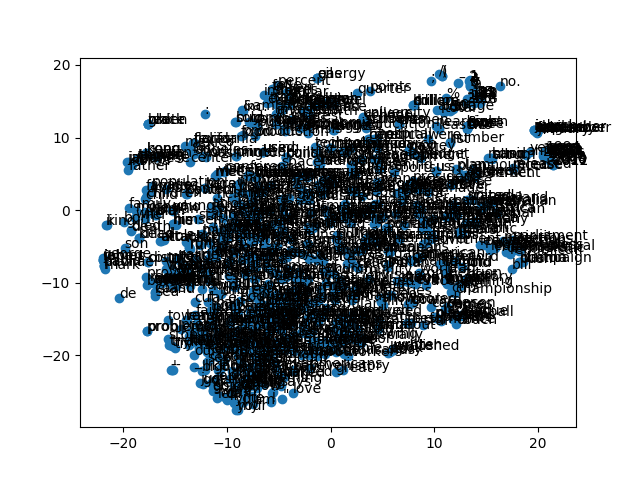

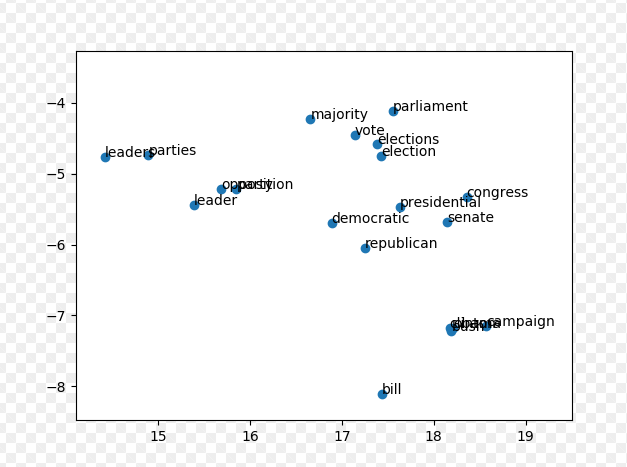

In [5]:
W = np.array(vals2)[:1000,1:].astype(float)
words = [vals2[i][0].decode('utf8') for i in range(10000)]

# use t-SNE to visualize pretrained GloVe embeddings
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib notebook

tsne = TSNE(n_components=2, random_state=0)
np.set_printoptions(suppress=True)
Y = tsne.fit_transform(W)
      
plt.scatter(Y[:, 0], Y[:, 1])
for label, x, y in zip(words, Y[:, 0], Y[:, 1]):
    plt.annotate(label, xy=(x, y), xytext=(0, 0),textcoords='offset points')
plt.show()

from IPython.display import Image 
Image(filename='Word Grouping.png')

This area clearly concerns government and politics, mainly variously groups and processes. It makes sense that these words are placed near each other.